<a href="https://colab.research.google.com/github/maxim-hrytsenia/BPM_Project/blob/master/Seq2Seq%2C_Masking%2C_Inference_and_BLEU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seq2Seq, Masking, Inference and BLEU

## Introduction

This notebook contains the Seq2Seq network with attention. This network is used for translation from English to French. It uses the following dataset: https://www.manythings.org/anki/fra-eng.zip

In addition, to an implementation of a Seq2Seq model based on GRU, this notebook also contains attention masking, demonstrates how the inference is done and how BLEU score is calculated.

This code is partially reused from: https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb

## Preparing Data

First, we'll import all the modules as before, with the addition of the `matplotlib` modules used for viewing the attention.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

from os import path
import unicodedata
import re
flatten = lambda l: [item for sublist in l for item in sublist]
from torch.autograd import Variable
from functools import partial

Next, we'll set the random seed for reproducability.

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

As before, we'll import spaCy and define the German and English tokenizers.

## Preparing French dataset

In [5]:
USE_CUDA = torch.cuda.is_available()
gpus = [0]
torch.cuda.set_device(gpus[0])

FloatTensor = torch.cuda.FloatTensor if USE_CUDA else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if USE_CUDA else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if USE_CUDA else torch.ByteTensor

In [6]:
if not path.exists("data/fra.txt"):
    !wget -P data https://www.manythings.org/anki/fra-eng.zip
    !unzip data/fra-eng.zip -d data

with open("data/fra.txt") as f:
    sentences = f.readlines()

# number of sentences
len(sentences)

178009

The *collate* function is overwritten for allowing the network to accept sequences with different lengthes.

In [7]:
def my_collate(batch, x_to_ix, y_to_ix):
    sorted_batch =  sorted(batch, key=lambda b:b[0].size(1), reverse=True) # sort by len
    x,y = list(zip(*sorted_batch))
    max_x = max([s.size(1) for s in x])
    max_y = max([s.size(1) for s in y])
    x_p, y_p = [], []
    for i in range(len(batch)):
        if x[i].size(1) < max_x:
            x_p.append(torch.cat([x[i], Variable(LongTensor([x_to_ix['<PAD>']] * (max_x - x[i].size(1)))).view(1, -1)], 1))
        else:
            x_p.append(x[i])
        if y[i].size(1) < max_y:
            y_p.append(torch.cat([y[i], Variable(LongTensor([y_to_ix['<PAD>']] * (max_y - y[i].size(1)))).view(1, -1)], 1))
        else:
            y_p.append(y[i])
        
    input_var = torch.cat(x_p)
    target_var = torch.cat(y_p)
    input_len = [list(map(lambda s: s ==0, t.data)).count(False) for t in input_var]
    target_len = [list(map(lambda s: s ==0, t.data)).count(False) for t in target_var]
    
    return input_var, target_var, input_len, target_len

In [8]:
def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

In [9]:
# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([,.!?])", r" \1 ", s)
    s = re.sub(r"[^a-zA-Z,.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

In [10]:
#to filter too short and too long sequences
MIN_LENGTH = 3
MAX_LENGTH = 15

To speed up the calculation, I use only 40K lines of the dataset.

In [11]:
sentences = sentences[:40000]

In [12]:
%%time
X_r, y_r = [], [] # raw

for parallel in sentences:
    so,ta = parallel[:-1].split('\t')[0:2]
    if so.strip() == "" or ta.strip() == "": 
        continue
    
    normalized_so = normalize_string(so).split()
    normalized_ta = normalize_string(ta).split()
    
    if len(normalized_so) >= MIN_LENGTH and len(normalized_so) <= MAX_LENGTH \
    and len(normalized_ta) >= MIN_LENGTH and len(normalized_ta) <= MAX_LENGTH:
        X_r.append(normalized_so)
        y_r.append(normalized_ta)
    

print(len(X_r), len(y_r))
print(X_r[0], y_r[0])

39778 39778
['i', 'see', '.'] ['je', 'comprends', '.']
CPU times: user 1.05 s, sys: 25 ms, total: 1.08 s
Wall time: 1.08 s


## Partition of data to test and train

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# to allow reusability, the random state is used
X_train, X_test, y_train, y_test = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

In [15]:
source_vocab = list(set(flatten(X_train)))
target_vocab = list(set(flatten(y_train)))
print(len(source_vocab), len(target_vocab))

4802 8069


In [16]:
source2index = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
for vo in source_vocab:
    if source2index.get(vo) is None:
        source2index[vo] = len(source2index)
index2source = {v:k for k, v in source2index.items()}

target2index = {'<PAD>': 0, '<UNK>': 1, '<SOS>': 2, '<EOS>': 3}
for vo in target_vocab:
    if target2index.get(vo) is None:
        target2index[vo] = len(target2index)
index2target = {v:k for k, v in target2index.items()}

In [17]:
def get_prepared_dataset(X, y):
  X_proc, y_proc = [], []
  for so, ta in zip(X, y):
    X_proc.append(prepare_sequence(so + ['<EOS>'], source2index).view(1, -1))
    y_proc.append(prepare_sequence(ta + ['<EOS>'], target2index).view(1, -1))
  return X_proc, y_proc

In [18]:
%%time
X_train_proc, y_train_proc = get_prepared_dataset(X_train, y_train) 
X_test_proc, y_test_proc = get_prepared_dataset(X_test, y_test)
train_data = list(zip(X_train_proc, y_train_proc))
test_data = list(zip(X_test_proc, y_test_proc))

CPU times: user 5.02 s, sys: 1.53 s, total: 6.54 s
Wall time: 6.57 s


In [19]:
# dataset class for data loader 
class MTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
    # import and initialize dataset    
        self.source = X
        self.output = y 
    
    def __getitem__(self, idx):
    # get item by index
        return self.source[idx], self.output[idx]
  
    def __len__(self):
    # returns length of data
        return len(self.source)

In [20]:
BATCH_SIZE = 256

In [21]:
train_dataset = MTDataset(X_train_proc, y_train_proc)
test_dataset = MTDataset(X_test_proc, y_test_proc)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True, 
                                           collate_fn=partial(my_collate, x_to_ix=source2index, y_to_ix=target2index))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=True, 
                                          collate_fn=partial(my_collate, x_to_ix=source2index, y_to_ix=target2index))

## Building the Model

### Encoder

Next up, we define the encoder.

The changes here all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. `packed_embedded` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packed_outputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

In [22]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src len, batch size, emb dim]     
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len) 
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

### Attention

The attention module is where we calculate the attention values over the source sentence. 

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.

The `forward` method now takes a `mask` input. This is a **[batch size, source sentence length]** tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. It is applied using `masked_fill`. This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [23]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat decoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
  
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention = [batch size, src len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [24]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #seq len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

### Seq2Seq

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference. 

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the `forward` method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the `create_mask` function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the `attentions` 

In [25]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.src_pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #src_len = [batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
                    
        batch_size = src.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)

        #mask = [batch size, src len]
                
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            #  and mask
            #receive output tensor (predictions) and new hidden state
            output, hidden, _ = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
        return outputs

## Training the Seq2Seq Model

Next up, initializing the model and placing it on the GPU.

In [26]:
INPUT_DIM = len(source2index)
OUTPUT_DIM = len(target2index)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = source2index["<PAD>"]
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, SRC_PAD_IDX, device).to(device)

Then, we initialize the model parameters.

In [27]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(4806, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(8073, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=8073, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

We'll print out the number of trainable parameters in the model, noticing that it has the exact same amount of parameters as the model without these improvements.

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,205,193 trainable parameters


Then we define our optimizer and criterion. 

The `ignore_index` for the criterion needs to be the index of the pad token for the target language, not the source language.

In [29]:
optimizer = optim.Adam(model.parameters())

In [30]:
TRG_PAD_IDX = target2index["<PAD>"]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Next, we'll define our training and evaluation loops.

As we are using `include_lengths = True` for our source field, `batch.src` is now a tuple with the first element being the numericalized tensor representing the sentence and the second element being the lengths of each sentence within the batch.

Our model also returns the attention vectors over the batch of source source sentences for each decoding time-step. We won't use these during the training/evaluation, but we will later for inference.

In [31]:
from tqdm import tqdm

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in tqdm(enumerate(iterator)):
        
        src, src_len = batch[0], batch[2]
        src = src.permute(1, 0)
        trg = batch[1]
        trg = trg.permute(1, 0)
        optimizer.zero_grad()
        
        output = model(src, src_len, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].flatten()
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [32]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len = batch[0], batch[2]
            src = src.permute(1, 0)
            trg = batch[1]
            trg = trg.permute(1, 0)
            output = model(src, src_len, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].flatten()

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Then, we'll define a useful function for timing how long epochs take.

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

The penultimate step is to train our model. Notice how it takes almost half the time as our model without the improvements added in this notebook.

In [34]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, test_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

125it [01:02,  1.99it/s]
0it [00:00, ?it/s]

Epoch: 01 | Time: 1m 15s
	Train Loss: 5.083 | Train PPL: 161.219
	 Val. Loss: 4.458 |  Val. PPL:  86.334


125it [01:03,  1.96it/s]
0it [00:00, ?it/s]

Epoch: 02 | Time: 1m 16s
	Train Loss: 3.854 | Train PPL:  47.202
	 Val. Loss: 3.964 |  Val. PPL:  52.681


125it [01:03,  1.97it/s]
0it [00:00, ?it/s]

Epoch: 03 | Time: 1m 16s
	Train Loss: 3.170 | Train PPL:  23.803
	 Val. Loss: 3.482 |  Val. PPL:  32.512


125it [01:03,  1.97it/s]
0it [00:00, ?it/s]

Epoch: 04 | Time: 1m 16s
	Train Loss: 2.610 | Train PPL:  13.594
	 Val. Loss: 3.206 |  Val. PPL:  24.679


125it [01:03,  1.98it/s]
0it [00:00, ?it/s]

Epoch: 05 | Time: 1m 16s
	Train Loss: 2.192 | Train PPL:   8.954
	 Val. Loss: 2.935 |  Val. PPL:  18.818


125it [01:03,  1.98it/s]
0it [00:00, ?it/s]

Epoch: 06 | Time: 1m 16s
	Train Loss: 1.826 | Train PPL:   6.206
	 Val. Loss: 2.777 |  Val. PPL:  16.078


125it [01:03,  1.97it/s]
0it [00:00, ?it/s]

Epoch: 07 | Time: 1m 16s
	Train Loss: 1.536 | Train PPL:   4.647
	 Val. Loss: 2.692 |  Val. PPL:  14.764


125it [01:03,  1.98it/s]
0it [00:00, ?it/s]

Epoch: 08 | Time: 1m 16s
	Train Loss: 1.311 | Train PPL:   3.709
	 Val. Loss: 2.615 |  Val. PPL:  13.666


125it [01:03,  1.98it/s]
0it [00:00, ?it/s]

Epoch: 09 | Time: 1m 16s
	Train Loss: 1.121 | Train PPL:   3.069
	 Val. Loss: 2.611 |  Val. PPL:  13.619


125it [01:04,  1.93it/s]


Epoch: 10 | Time: 1m 17s
	Train Loss: 0.994 | Train PPL:   2.701
	 Val. Loss: 2.578 |  Val. PPL:  13.167


Finally, we load the parameters from our best validation loss and get our results on the test set.

We get the improved test perplexity whilst almost being twice as fast!

In [35]:
model.load_state_dict(torch.load('tut4-model.pt'))

test_loss = evaluate(model, test_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.565 | Test PPL:  12.996 |


## Inference

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples shown in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translate_sentence` will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- tokenize the source sentence if it has not been tokenized (is a string)
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- get the length of the source sentence and convert to a tensor
- feed the source sentence into the encoder
- create the mask for the source sentence
- create a list to hold the output sentence, initialized with an `<sos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length
  - get the input tensor, which should be either `<sos>` or the last predicted token
  - feed the input, all encoder outputs, hidden state and mask into the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention values over the sequence

In [36]:
def translate_sentence(sentence, source2index, target2index, index2target, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('fr')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
    tokens = ["<SOS>"] + tokens + ["<EOS>"]
        
    src_indexes = [source2index[token]  if token in source2index else source2index["<UNK>"] for token in tokens]
    
    src_tensor = LongTensor(src_indexes).unsqueeze(1).to(device)

    src_len = [len(src_indexes)]
    
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor, src_len)

    mask = model.create_mask(src_tensor)
        
    trg_indexes = [target2index["<SOS>"]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    
    for i in range(max_len):

        trg_tensor = LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs, mask)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == target2index["<EOS>"]:
            break
    
    trg_tokens = [index2target[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

Next, we'll make a function that displays the model's attention over the source sentence for each target token generated.

In [37]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<SOS>']+[t.lower() for t in sentence]+['<EOS>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Now, we'll grab some translations from our dataset and see how well our model did. Note, we're going to cherry pick examples here so it gives us something interesting to look at, but feel free to change the `example_idx` value to look at different examples.

First, we'll get a source and target from our dataset.

In [38]:
example_idx = 25
src = X_train[example_idx]
trg = y_train[example_idx]
#src = train_data[example_idx][0]
#trg = train_data[example_idx][1]

print(f'src = {src}')
print(f'trg = {trg}')

src = ['we', 'all', 'know', 'it', '.']
trg = ['nous', 'le', 'savons', 'toutes', '.']


Then we'll use our `translate_sentence` function to get our predicted translation and attention. We show this graphically by having the source sentence on the x-axis and the predicted translation on the y-axis. The lighter the square at the intersection between two words, the more attention the model gave to that source word when translating that target word.

Below is an example the model attempted to translate, it gets the translation correct except changes *are fighting* to just *fighting*.

In [39]:
translation, attention = translate_sentence(src, source2index, target2index, 
                                            index2target, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['le', 'tout', 'le', 'savent', '.', '<EOS>']


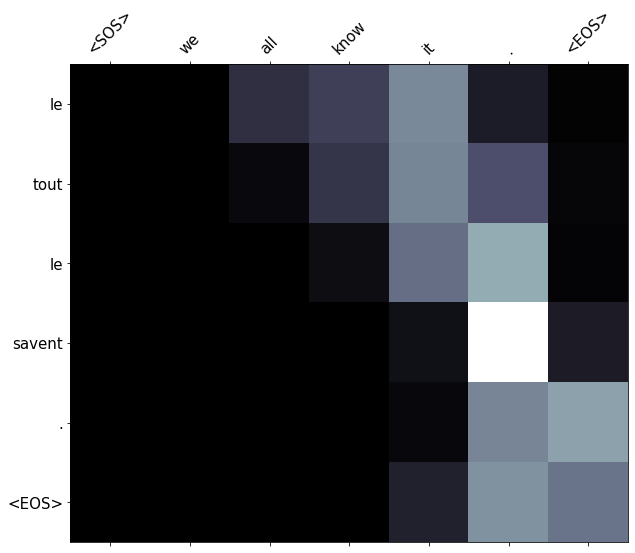

In [40]:
display_attention(src, translation, attention)

Translations from the training set could simply be memorized by the model. So it's only fair we look at translations from the validation and testing set too.

Starting with the validation set, let's get an example.

In [41]:
example_idx = 14

src = X_test[example_idx]
trg = y_test[example_idx]

print(f'src = {src}')
print(f'trg = {trg}')

src = ['i', 'bike', 'to', 'work', '.']
trg = ['je', 'me', 'rends', 'au', 'travail', 'en', 'velo', '.']


Then let's generate our translation and view the attention.

Here, we can see the translation is the same except for swapping *female* with *woman*.

predicted trg = ['de', 'de', 'ton', 'travail', '.', '<EOS>']


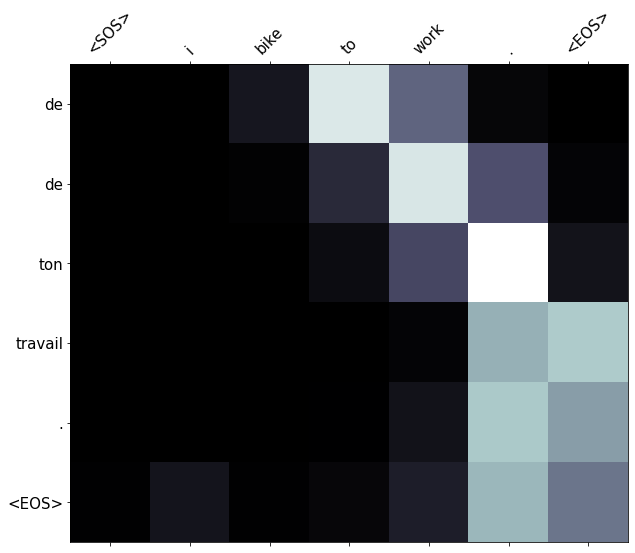

In [42]:
translation, attention = translate_sentence(src, source2index, target2index, index2target, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

Finally, let's get an example from the test set.

In [43]:
example_idx = 18

src = X_test[example_idx]
trg = y_test[example_idx]

print(f'src = {src}')
print(f'trg = {trg}')

src = ['i', 'may', 'be', 'wrong', '.']
trg = ['j', 'ai', 'peut', 'etre', 'tort', '.']


predicted trg = ['pourrait', 'que', 'j', 'aie', 'tort', '.', '<EOS>']


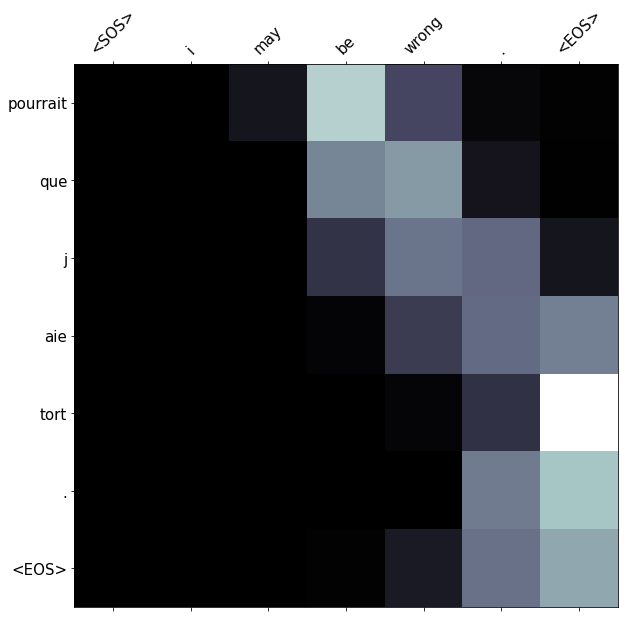

In [44]:
translation, attention = translate_sentence(src, source2index, target2index, index2target, model, device)

print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

## BLEU

Previously we have only cared about the loss/perplexity of the model. However there metrics that are specifically designed for measuring the quality of a translation - the most popular is *BLEU*. Without going into too much detail, BLEU looks at the overlap in the predicted and actual target sequences in terms of their n-grams. It will give us a number between 0 and 1 for each sequence, where 1 means there is perfect overlap, i.e. a perfect translation, although is usually shown between 0 and 100. BLEU was designed for multiple candidate translations per source sequence, however in this dataset we only have one candidate per source.

We define a `calculate_bleu` function which calculates the BLEU score over a provided TorchText dataset. This function creates a corpus of the actual and predicted translation for each source sentence and then calculates the BLEU score.

In [45]:
! pip install torchtext==0.6.0 

In [46]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(X, y, source2index, target2index, index2target, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in zip(X, y):
        
        src = datum[0]
        trg = datum[1]
        
        pred_trg, _ = translate_sentence(src, source2index, target2index, index2target, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [47]:
bleu_score = calculate_bleu(X_test, y_test, source2index, target2index, index2target, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 11.86
